<span style="font-size:18px">
&nbsp;&nbsp;&nbsp;&nbsp; The purpose of this project is to build a Toxicity Detection System that automatically identifies harmful, offensive, or toxic content in text. With the massive growth of online platforms, detecting toxic language has become crucial for maintaining healthy digital communication and fostering safe online communities. This system preprocesses and cleans text data, leverages LSTM and CNN models with GloVe embeddings to build a multi-label classification framework, and evaluates their performance to ensure reliable detection. Real-world applications include moderating social media discussions, filtering abusive messages in online chats and games, promoting healthier workplace communication, and supporting online communities by reducing the spread of toxic language. Ultimately, this project demonstrates how artificial intelligence can be applied to improve online safety and digital well-being. 
  </span>

# Importing Libraries

In [1]:
# Import necessary libraries
import os
import re
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm_notebook
import nltk
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
from sklearn.metrics import confusion_matrix, classification_report
!pip install rapidfuzz pyspellchecker
from rapidfuzz import fuzz, process
import warnings
warnings.filterwarnings('ignore')
print("All libaries imported successfully!")

2025-08-17 16:20:16.851259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755447617.162070      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755447617.261568      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.5 MB/s eta 0:00:00:00:0100:01
All libaries imported successfully!


In [2]:
# Download NLTK stopwords and load them
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading Data

In [6]:
# Setting constants
MAX_NUM_WORDS = 100000
MAX_SEQUENCE_LENGTH = 200
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 100
GLOVE_DIR = "/kaggle/input/glove6b100dtxt/glove.6B.100d.txt"
MODEL_PATH = "/kaggle/working/model-{epoch:02d}-{val_loss:.2f}.keras"

# Load training and test datasets
train=pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv")
test=pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.shape

(159571, 8)

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


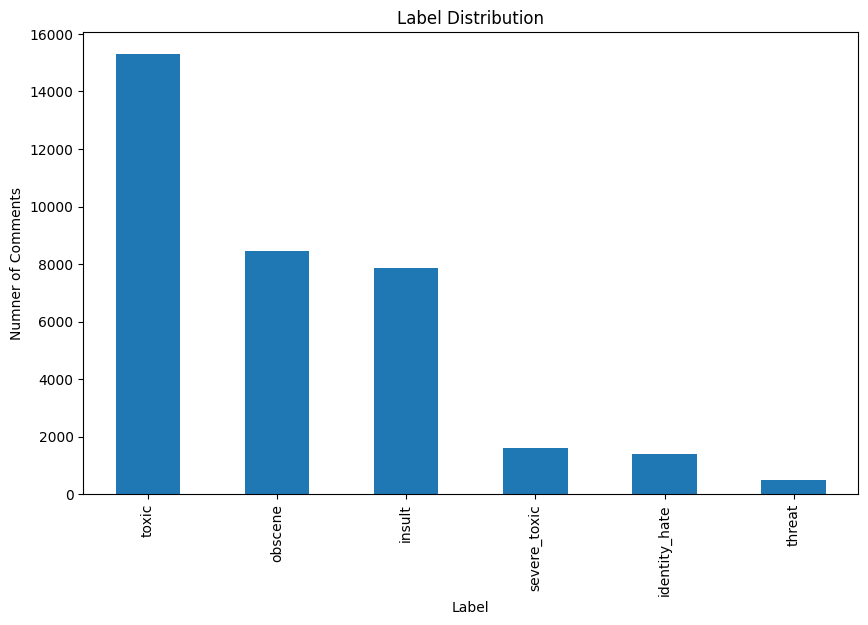

In [9]:
# class distribution
label_cols=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
print(train[label_cols].sum())

plt.figure(figsize=(10,6))
train[label_cols].sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Numner of Comments")
plt.show()

# Data Preprocessing

In [10]:
comment_train=train["comment_text"]
comment_test=test["comment_text"]
comment_train=list(comment_train)

In [11]:
TOXIC_SLANG = [
    "noob", "nub", "scrub", "loser", "trash", "moron", "idiot", "stupid",
    "dumbass", "douche", "jerk", "bastard", "retard", "clown", "ez", "rekt",
    "gitgud", "afk", "smurf", "tilt", "ragequit", "fag", "faggot", "slut",
    "whore", "cunt", "nigga", "nigger", "fuck", "shit", "bitch", "asshole",
    "dick", "hoe", "slut", "pussy", "bitch", "shit", "faggot", "gay"
]

LEET_MAP = {
    '@':'a', '4':'a', '1':'i', '!':'i', '|':'i',
    '3':'e', '0':'o', '$':'s', '5':'s',
    '7':'t', '+':'t', '8':'b'
}

In [26]:
# data cleaning
def clean_text(text, remove_stopwords=True):
  if pd.isna(text):
    return ""
  text = str(text).replace('\n', '')

  text = text.lower()
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
  text = re.sub(r"\s+", " ", text).strip()

  #remove stopwords
  if remove_stopwords:
      text = text.split()
      text = ' '.join(word for word in text if word not in stop_words)

  return text

# spell = SpellChecker()

# def spell_correct(text):
#   corrected_words = []
  
#   for word in text.split():
#       if word in TOXIC_SLANG:
#           corrected_words.append(word)
#       else:
#           correction = spell.correction(word)
#           if correction:  
#               corrected_words.append(correction)
#           else:  
#               corrected_words.append(word)  # fallback to original word
              
#   return " ".join(corrected_words)

# normalize leetspeak
def normalize_leetspeak(text):
  for k, v in LEET_MAP.items():
    text = text.replace(k, v)
  return text


def word_to_regex(word):
  pattern = ""
  for c in word:
    c_class = f"[{c}{c.upper()}0-9!@#\\$%&*]*"
    pattern += c_class + r"\s*"
  return re.compile(pattern)

TOXIC_REGEX = {w: word_to_regex(w) for w in TOXIC_SLANG}

def fuzzy_match(word, threshold=85):
  match, score, _ = process.extractOne(word, TOXIC_SLANG, scorer=fuzz.ratio)
  return match if score >= threshold else None

def detect_toxic(text):
  text_norm = normalize_leetspeak(text.lower())

  detected = {}

  tokens = re.findall(r"\w+", text_norm)

  # regex pass
  for tokens in tokens:
      for word, pattern in TOXIC_REGEX.items():
          if pattern.search(text_norm):
              detected[word] = 100.0   # strong match

  # fuzzy matching
  for token in tokens:
      if tokens not in detected:
          match = fuzzy_match(token)
          if match:
              detected[match] = 90.0   # softer match

  return detected

In [27]:
def preprocess_text(text, beAggressive=False, remove_stopwords=True):
    
    cleaned = clean_text(text, remove_stopwords=remove_stopwords)
    
    normalized = normalize_leetspeak(cleaned)  # from detect_toxic()

  # if do_spellcheck:
  #   normalized = spell_correct(normalized)
    
    if beAggressive:
        toxic_hits = detect_toxic(normalized)
        
    return normalized, toxic_hits

  return normalized, None

In [28]:
# while True:
#     text = input("Enter a text (or type 'exit' to quit): ")
#     if text.lower() == "exit":
#         break

#     result = preprocess_text(text, beAggressive=True)
#     original, corrected = result
#     print("\nOriginal :", original)
#     print("-" * 50)

In [29]:
texts = []
for line in tqdm_notebook(comment_train, total=len(comment_train)):
    texts.append(preprocess_text(line, beAggressive=False))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [30]:
# tokenize the text data
texts = [t[0] for t in texts]
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)

In [31]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print("Vocabulary Size:", len(word_index))

Vocabulary Size: 191083


In [32]:
# pad sequence
data = pad_sequences(sequences, padding="post", maxlen=MAX_SEQUENCE_LENGTH)
print("Shape of Data Tensor:", data.shape)

y=train[label_cols].values
print("Shape of Label Tensor:", y.shape)

Shape of Data Tensor: (159571, 200)
Shape of Label Tensor: (159571, 6)


In [33]:
# split data into training and validation sets
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
label = y[indices]

num_validation_sample = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_sample]
y_train = label[: -num_validation_sample]
x_val = data[-num_validation_sample:]
y_val = label[-num_validation_sample:]

print("Training", y_train.sum(axis=0))
print("Validation", y_val.sum(axis=0))

Training [12176  1252  6698   384  6257  1103]
Validation [3118  343 1751   94 1620  302]


In [34]:
print('Tokenized Sentences:', data[10])
print("One_Hot_Labes:", label[10])

Tokenized Sentences: [  39    4   41    6  126  353   55   47  346 1100  123 1867  541    3
  875 1759   93  704  323   93  380 2877  362   16  991   93 3823  102
 2555    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0 

In [35]:
# embedding with GloVe
embedding_index = {}

with open(GLOVE_DIR, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding_index[word] = np.asarray(values[1:], dtype='float32')

print("Proceding with Embedded Matrix", end = '')
embedding_matrix = np.zeros((len(word_index)+1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print("\nEmbedding Completed")

Proceding with Embedded Matrix
Embedding Completed


In [36]:
# focal loss function to handle class imbalance
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
      epsilon = K.epsilon()
      y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

      alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
      p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)

      focal_weight = alpha_t * K.pow((1 - p_t), gamma)
      focal_loss = -focal_weight * K.log(p_t + epsilon)

      return K.mean(focal_loss)
    return focal_loss_fixed

In [37]:
# sample weights to handle class imbalance
def calculate_sample_weights(y_train, label_cols, max_weight=5.0):
    sample_weights = np.ones(len(y_train))

    for i, col in enumerate(label_cols):
        neg_count = np.sum(y_train[:, i] == 0)
        pos_count = np.sum(y_train[:, i] == 1)

        if pos_count > 0:
            pos_weight = min(neg_count / pos_count, max_weight)
            sample_weights[y_train[:, i] == 1] *= pos_weight

    # normalize weights
    sample_weights = sample_weights / np.mean(sample_weights)
    return sample_weights

sample_weights = calculate_sample_weights(y_train, label_cols)

# LSTM - CNN Model

In [38]:
# define the model architecture
sequence_input = Input(shape = (MAX_SEQUENCE_LENGTH,), dtype = 'int32')

embedding_layer = Embedding(len(word_index)+1, EMBEDDING_DIM,
                             weights = [embedding_matrix],
                             trainable = True,
                             name = 'embeddings')(sequence_input)

embedding_layer = Dropout(0.2)(embedding_layer)

I0000 00:00:1755365951.065995      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755365951.066759      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [39]:
# CNN layers
conv_blocks = []
for kernel_size in [3, 4, 5]:
    conv = Conv1D(64,
                  kernel_size,
                  activation='relu',
                  padding='same',
                  kernel_regularizer=l2(0.01))(embedding_layer)
    conv = BatchNormalization()(conv)
    conv = Dropout(0.3)(conv)
    conv_blocks.append(conv)

x = Concatenate()(conv_blocks)

# LSTM layers
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32))(x)

# Dense layers
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation = 'relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

preds = Dense(6, activation = 'sigmoid')(x)

In [40]:
# compile
model = Model(sequence_input, preds)
model.compile(loss = focal_loss(gamma=2., alpha=0.25),
              optimizer = Adam(learning_rate=0.001),
              metrics = ['accuracy', AUC()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embeddings          │ (None, 200, 100)  │ 19,108,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 200, 100)  │          0 │ embeddings[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 200, 64)   │     19,264 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 200, 64)   │     25,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 200, 64)   │     32,064 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 200, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 200, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 200, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200, 192)  │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_2[0][0],  │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 128)  │    131,584 │ concatenate[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]   

 Total params: 19,376,694 (73.92 MB)

 Trainable params: 19,375,926 (73.91 MB)

 Non-trainable params: 768 (3.00 KB)

In [41]:
# callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6),
    ModelCheckpoint(filepath=MODEL_PATH, monitor='val_loss', save_best_only=True,save_weights_only=False, verbose=1)
]

In [42]:
# training model
history = model.fit(x_train, y_train,
                    epochs = 20,
                    batch_size = 64,
                    validation_data = (x_val, y_val),
                    sample_weight=sample_weights,
                    callbacks= callbacks
)

Epoch 1/20


I0000 00:00:1755365984.472193     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


1995/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3528 - auc: 0.6456 - loss: 1.0420
Epoch 1: val_loss improved from inf to 0.02604, saving model to /kaggle/working/model-01-0.03.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 121s 53ms/step - accuracy: 0.3529 - auc: 0.6456 - loss: 1.0417 - val_accuracy: 0.9939 - val_auc: 0.9337 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 2/20
1994/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7592 - auc: 0.9245 - loss: 0.0192
Epoch 2: val_loss improved from 0.02604 to 0.01459, saving model to /kaggle/working/model-02-0.01.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 110s 55ms/step - accuracy: 0.7592 - auc: 0.9245 - loss: 0.0192 - val_accuracy: 0.9939 - val_auc: 0.9524 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 3/20
1994/1995 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8854 - auc: 0.9448 - loss: 0.0132
Epoch 3: val_loss improved from 0.01459 to 0.00807, saving model to /kaggle/working/model-03-0.01.keras
1995/1995 ━━━━━━━━━━━━━━━━━━━━ 109s 55

# Evaluation and Visualization

In [49]:
# predicting on test data
test = test[['id', 'comment_text']].merge(test_labels, on="id", how="left")

test_sequences = tokenizer.texts_to_sequences(test["comment_text"].astype(str))
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")
y_test = test[label_cols].values

y_test_pred = model.predict(x_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

exact_match = np.all(y_test_pred_binary == y_test, axis=1)
test_accuracy = np.mean(exact_match)
print(f"Exact Match Accuracy: {test_accuracy:.4f}")

per_class_accuracy = (y_test_pred_binary == y_test).mean(axis=0)
for label, acc in zip(label_cols, per_class_accuracy):
    print(f"{label} Accuracy: {acc:.4f}")

print("\nConfusion Matrices and Classification Reports:")
for i, label in enumerate(label_cols):
    cm = confusion_matrix(y_test[:, i], y_test_pred_binary[:, i], labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    print(f"\nLabels: {label}:")
    print("Confusion Matrix:")
    print(cm)
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")

    print("\nClassification Report:")
    print(classification_report(y_test[:, i], 
                                y_test_pred_binary[:, i], 
                                labels=[0, 1],
                                target_names=[f"Not {label}", label]))

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 50s 10ms/step
Exact Match Accuracy: 0.3754
toxic Accuracy: 0.3929
severe_toxic Accuracy: 0.4153
obscene Accuracy: 0.4031
threat Accuracy: 0.4163
insult Accuracy: 0.4003
identity_hate Accuracy: 0.4131

Confusion Matrices and Classification Reports:

Labels: toxic:
Confusion Matrix:
[[56476  1412]
 [ 2383  3707]]
True Negatives: 56476
False Positives: 1412
False Negatives: 2383
True Positives: 3707

Classification Report:
              precision    recall  f1-score   support

   Not toxic       0.43      0.98      0.60     57888
       toxic       0.17      0.61      0.27      6090

   micro avg       0.39      0.94      0.55     63978
   macro avg       0.30      0.79      0.43     63978
weighted avg       0.40      0.94      0.56     63978


Labels: severe_toxic:
Confusion Matrix:
[[63611     0]
 [  367     0]]
True Negatives: 63611
False Positives: 0
False Negatives: 367
True Positives: 0

Classification Report:
                  precision    recall  f1-

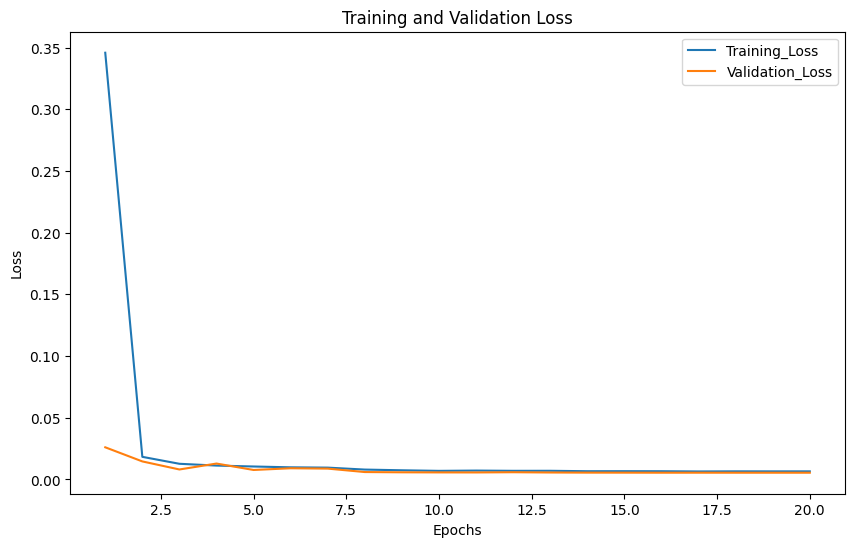

In [50]:
# plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,6))
sns.lineplot(x=epochs, y=loss, label = 'Training_Loss')
sns.lineplot(x=epochs, y=val_loss, label = 'Validation_Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

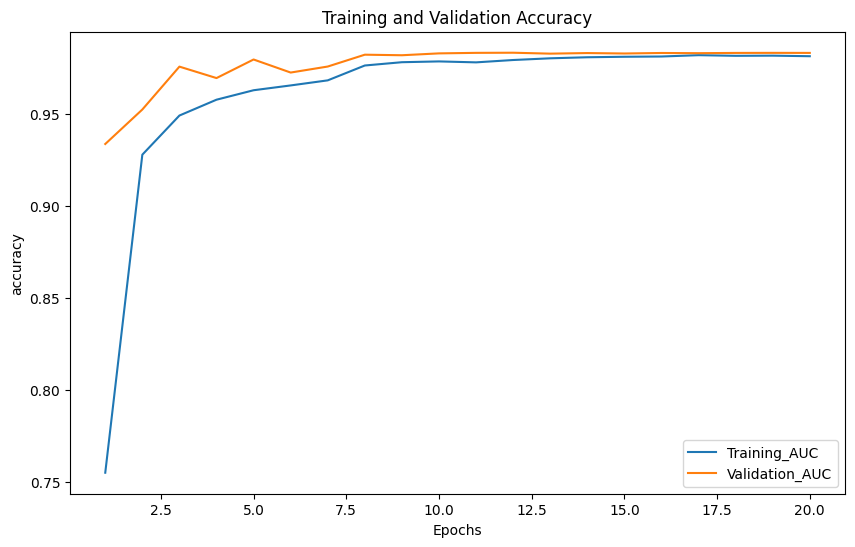

In [51]:
# plot training and validation auc
accuracy = history.history['auc']
val_accuracy = history.history['val_auc']

epochs = range(1, len(accuracy)+1)

plt.figure(figsize=(10,6))
sns.lineplot(x=epochs, y=accuracy, label = 'Training_AUC')
sns.lineplot(x=epochs, y=val_accuracy, label = 'Validation_AUC')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Input Submission

In [52]:
# function to predict toxicity levels for a given comment
def predict_toxicity(comment):
    comment = clean_text(comment)
    sequence = tokenizer.texts_to_sequences([comment])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    predictions = model.predict(padded_sequence)[0]
    predictions_pct = predictions * 100

    toxic_scores = list(zip(label_cols, predictions_pct.tolist()))

    threshold = 20
    detected = [(label, score) for label, score in toxic_scores if score > threshold]

    if not detected:
        return "This is not toxic"

    toxic_scores_sorted = sorted(toxic_scores, key=lambda x: x[1], reverse=True)

    output = "The comment is toxic.\nThe score (out of 100) of each trait are:\n"
    for label, score in toxic_scores_sorted:
        output += f" {label}: {score:.2f},\n"

    return output.strip().rstrip(',')


# interactive loop
while True:
    user_input = input("\nEnter a comment (or type 'exit' to quit): ")
    if user_input.lower() == "exit":
        print("Exiting...")
        break

    prediction_result = predict_toxicity(user_input)
    print(prediction_result)


Enter a comment (or type 'exit' to quit):  u fck1ng pighead, hope you d1e a$$hole


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
The comment is toxic.
The score (out of 100) of each trait are:
 toxic: 55.69,
 obscene: 37.77,
 insult: 35.09,
 severe_toxic: 19.16,
 identity_hate: 19.13,
 threat: 13.93



Enter a comment (or type 'exit' to quit):  exit


Exiting...


In [57]:
# save model and pickle 
def save_model_and_tokenizer(model, tokenizer, save_dir="saved_models"):
    """Save the trained model and tokenizer"""
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(save_dir, "toxic_classifier_model.keras")
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    # Save the tokenizer
    tokenizer_path = os.path.join(save_dir, "tokenizer.pkl")
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Tokenizer saved to: {tokenizer_path}")
    
    # Save label names
    labels_path = os.path.join(save_dir, "labels.pkl")
    labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    with open(labels_path, 'wb') as handle:
        pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Labels saved to: {labels_path}")
    
    return model_path, tokenizer_path, labels_path

save_model_and_tokenizer(model, tokenizer)

Model saved to: saved_models/toxic_classifier_model.keras
Tokenizer saved to: saved_models/tokenizer.pkl
Labels saved to: saved_models/labels.pkl


('saved_models/toxic_classifier_model.keras',
 'saved_models/tokenizer.pkl',
 'saved_models/labels.pkl')